In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetSegmentation(nn.Module):
    def __init__(self, num_classes=3):
        super(PointNetSegmentation, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Entrada: 3 (XYZ)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)  # Salida: num_classes (por ejemplo, 3 para las etiquetas)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

# Directorio de datos
data_dir = '/content/drive/MyDrive/DataMaize'
plants = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print("Plantas disponibles:", plants)

# Función para cargar puntos y etiquetas
def load_xyz_and_labels(file_path):
    data = np.loadtxt(file_path)
    points = data[:, :3]  # Coordenadas XYZ
    labels = None
    if data.shape[1] > 3:
        labels = data[:, 3]
    return points, labels


# Función para normalizar las coordenadas de los puntos
def normalize_points(points):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(points)

# Función para hacer subsample de los puntos y etiquetas
def subsample_points_and_labels(points, labels, num_points=25000):
    if len(points) > num_points:
        idx = np.random.choice(len(points), num_points, replace=False)
        return points[idx], labels[idx]
    return points, labels

# Cargar datos (solo los archivos con etiquetas)
all_points = []
all_labels = []

for plant in plants:
    plant_dir = os.path.join(data_dir, plant)
    for file in os.listdir(plant_dir):
        file_path = os.path.join(plant_dir, file)

        if file.endswith('_a.txt'):  # Archivos con etiquetas
            points, labels = load_xyz_and_labels(file_path)
            if labels is not None and len(labels) == len(points):
                print(f"Archivo procesado correctamente: {file}")
                points = normalize_points(points)
                points, labels = subsample_points_and_labels(points, labels)
                all_points.append(points)
                all_labels.append(labels)
            else:
                print(f"Archivo ignorado: {file}")

all_points = np.vstack(all_points) if all_points else np.array([])
all_labels = np.hstack(all_labels) if all_labels else np.array([])

if len(all_points) == len(all_labels):
    train_points, val_test_points, train_labels, val_test_labels = train_test_split(
        all_points, all_labels, test_size=0.3, random_state=42
    )
    val_points, test_points, val_labels, test_labels = train_test_split(
        val_test_points, val_test_labels, test_size=0.33, random_state=42
    )
else:
    raise ValueError("Los datos no son consistentes para la segmentación.")


train_labels = np.clip(train_labels, 0, 2)
val_labels = np.clip(val_labels, 0, 2)
test_labels = np.clip(test_labels, 0, 2)

train_points_tensor = torch.tensor(train_points, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_points_tensor = torch.tensor(val_points, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_points_tensor = torch.tensor(test_points, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Modelo
class PointNet(nn.Module):
    def __init__(self, num_classes=3):
        super(PointNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1024)
        self.fc4 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = PointNet(num_classes=3)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_points_tensor, train_labels_tensor, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_points_tensor)
        loss = criterion(output, train_labels_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

# Entrenamiento
train_model(model, train_points_tensor, train_labels_tensor)

# Evaluación
def evaluate_model(model, test_points_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        output = model(test_points_tensor)
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

evaluate_model(model, test_points_tensor, test_labels_tensor)


Plantas disponibles: ['Maize02', 'Maize06', 'Maize01', 'Maize05', 'Maize04', 'Maize03', 'Maize07']
Archivo procesado correctamente: M02_0313_a.txt
Archivo procesado correctamente: M02_0315_a.txt
Archivo procesado correctamente: M02_0317_a.txt
Archivo procesado correctamente: M02_0319_a.txt
Archivo procesado correctamente: M02_0321_a.txt
Archivo procesado correctamente: M02_0324_a.txt
Archivo procesado correctamente: M02_0325_a.txt
Archivo procesado correctamente: M06_0313_a.txt
Archivo procesado correctamente: M06_0315_a.txt
Archivo procesado correctamente: M06_0317_a.txt
Archivo procesado correctamente: M06_0319_a.txt
Archivo procesado correctamente: M06_0321_a.txt
Archivo procesado correctamente: M06_0324_a.txt
Archivo procesado correctamente: M06_0325_a.txt
Archivo procesado correctamente: M01_0313_a.txt
Archivo procesado correctamente: M01_0315_a.txt
Archivo procesado correctamente: M01_0317_a.txt
Archivo procesado correctamente: M01_0319_a.txt
Archivo procesado correctamente: M01_

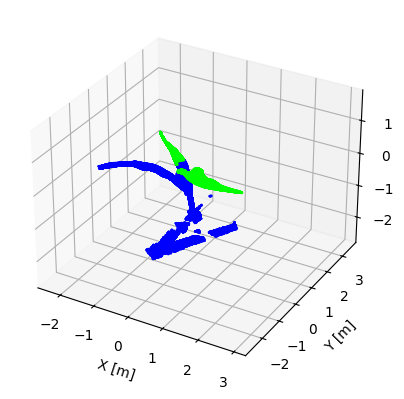

Etiquetas únicas predichas: [0 1]


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Función para segmentar la planta
def segment_plant(model, points):
    model.eval()  # Poner el modelo en modo evaluación
    points_tensor = torch.Tensor(points)  # Convertir los puntos en un tensor
    with torch.no_grad():  # No necesitamos gradientes para la predicción
        preds = model(points_tensor)  # Predicción
        _, predicted_labels = torch.max(preds, dim=1)  #
    return predicted_labels.numpy()

# Cargar y normalizar los puntos de la nueva planta
def load_xyz_and_labels(file_path):
    data = np.loadtxt(file_path)
    points = data[:, :3]  # XYZ
    labels = data[:, 3] if data.shape[1] > 3 else None  # Etiquetas, si están presentes
    return points, labels

def normalize_points(points):
    # Normalizar los puntos XYZ
    mean = np.mean(points, axis=0)
    std = np.std(points, axis=0)
    return (points - mean) / std

# Ruta al archivo de puntos
file_path = '/content/drive/MyDrive/DataMaize/Maize01/M01_0320.txt'

# Cargar y normalizar los datos
new_plant_points, _ = load_xyz_and_labels(file_path)
new_plant_points = normalize_points(new_plant_points)

# Predecir la segmentación
predicted_labels = segment_plant(model, new_plant_points)

xyz = new_plant_points
labels = predicted_labels

colors = np.array([
    [0, 0, 1] if label == 0 else [0, 1, 0] if label == 1 else [1, 0, 0]
    for label in labels
])

# Crear el gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualizar los puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors, s=0.5)

# Etiquetas de los ejes
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# Mostrar gráfico
plt.show()
# Revisar las etiquetas únicas predichas
unique_labels = np.unique(predicted_labels)
print("Etiquetas únicas predichas:", unique_labels)



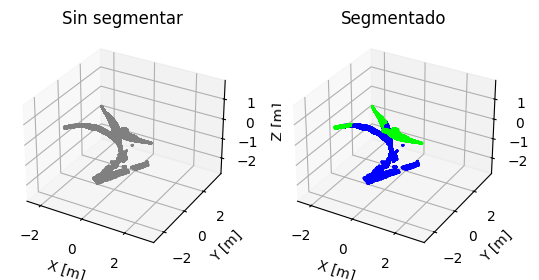

Etiquetas únicas predichas: [0 1]


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Función para segmentar la planta
def segment_plant(model, points):
    model.eval()  # Poner el modelo en modo evaluación
    points_tensor = torch.Tensor(points)  # Convertir los puntos en un tensor
    with torch.no_grad():  # No necesitamos gradientes para la predicción
        preds = model(points_tensor)  # Predicción
        _, predicted_labels = torch.max(preds, dim=1)  # Obtener las predicciones
    return predicted_labels.numpy()

# Cargar y normalizar los puntos de la nueva planta
def load_xyz_and_labels(file_path):
    data = np.loadtxt(file_path)
    points = data[:, :3]  # XYZ
    labels = data[:, 3] if data.shape[1] > 3 else None  # Etiquetas, si están presentes
    return points, labels

def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points, axis=0)
    return (points - mean) / std

# Ruta al archivo de puntos
file_path = '/content/drive/MyDrive/DataMaize/Maize01/M01_0320.txt'

# Cargar y normalizar los datos
new_plant_points, _ = load_xyz_and_labels(file_path)
new_plant_points = normalize_points(new_plant_points)

# Predecir la segmentación
predicted_labels = segment_plant(model, new_plant_points)

# Visualización sin segmentar
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(new_plant_points[:, 0], new_plant_points[:, 1], new_plant_points[:, 2], c='gray', s=0.5)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title("Sin segmentar")

# Visualización segmentada
colors = np.array([
    [0, 0, 1] if label == 0 else [0, 1, 0] if label == 1 else [1, 0, 0]
    for label in predicted_labels
])

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(new_plant_points[:, 0], new_plant_points[:, 1], new_plant_points[:, 2], c=colors, s=0.5)
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')
ax2.set_zlabel('Z [m]')
ax2.set_title("Segmentado")

plt.show()

# Revisar las etiquetas únicas predichas
unique_labels = np.unique(predicted_labels)
print("Etiquetas únicas predichas:", unique_labels)


Epoch [1/10], Loss: 0.7574567794799805
Epoch [2/10], Loss: 0.7245197296142578
Epoch [3/10], Loss: 0.6917954087257385
Epoch [4/10], Loss: 0.6605304479598999
Epoch [5/10], Loss: 0.6317456960678101
Epoch [6/10], Loss: 0.6057356595993042
Epoch [7/10], Loss: 0.5821287035942078
Epoch [8/10], Loss: 0.5602543950080872
Epoch [9/10], Loss: 0.5398186445236206
Epoch [10/10], Loss: 0.5211867690086365


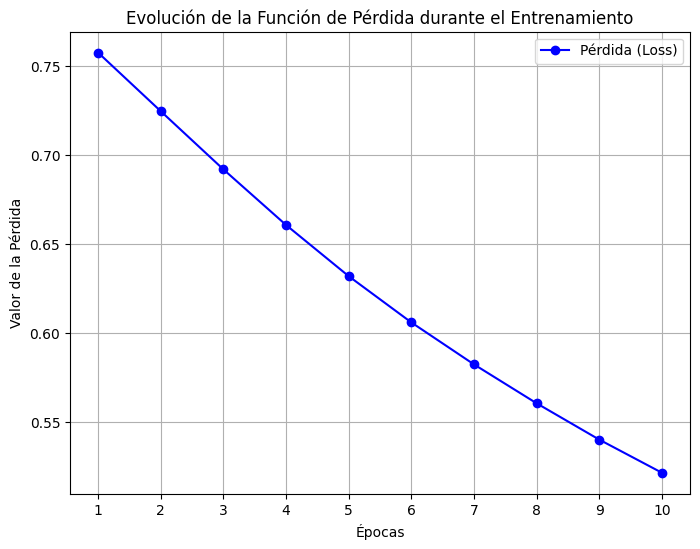

In [ ]:
import matplotlib.pyplot as plt

# Función para entrenar el modelo y guardar la pérdida en cada época
def train_model_with_loss_tracking(model, train_points_tensor, train_labels_tensor, epochs=10):
    model.train()
    loss_values = []  # Lista para almacenar los valores de pérdida por época
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_points_tensor)
        loss = criterion(output, train_labels_tensor)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())  # Guardar el valor de la pérdida
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

    return loss_values  # Devolver los valores de pérdida

# Entrenamiento con seguimiento de la pérdida
loss_values = train_model_with_loss_tracking(model, train_points_tensor, train_labels_tensor)

# Graficar la evolución de la función de pérdida
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), loss_values, marker='o', linestyle='-', color='b', label='Pérdida (Loss)')
plt.title('Evolución de la Función de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Valor de la Pérdida')
plt.grid(True)
plt.xticks(range(1, 11))
plt.legend()
plt.show()
